In [1]:
import random
import networkx as nx
import numpy as np
from node2vec import Node2Vec
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, Linear
import torch.nn.functional as F
from torch.autograd import Variable
import gensim

# Data Generation

In [2]:
MAX_NODES			= 1000
MIN_NODES			= 100
MAX_S				= 100
MIN_S				= 10
MIN_V               = 2
MAX_V               = 25
MIN_P_IN 			= 0.05
MAX_P_IN            = 0.4
MIN_P_OUT			= 0.01
MAX_P_OUT           = 0.05

def getNode2VecEmbedding(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)  # Use temp_folder for big graphs
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    return model.wv

def generate_community_graph():
    n = np.random.randint(MIN_NODES, MAX_NODES+1)
    s = np.random.randint(MIN_S, MAX_S+1)
    v = np.random.randint(MIN_V, MAX_V+1)
    p_in = float(np.random.randint(int(1000*MIN_P_IN), int(1000*(MAX_P_IN)))) / 1000.0
    p_out = float(np.random.randint(int(1000*MIN_P_OUT), int(1000*(MAX_P_OUT)))) / 1000.0

    G = nx.gaussian_random_partition_graph(n, s, v, p_in, p_out)
    return G

def generate_graphs(n=50):
    for i in range(n):
        G = generate_community_graph()

        data = torch_geometric.utils.convert.from_networkx(G)

        data.num_nodes = G.number_of_nodes()

        node_labels = getNode2VecEmbedding(G)

        data.y = []
        for n in G:
            data.y.append(node_labels[str(n)])
        
        torch.save(data, './data/graph' + str(i) + '.pt')

# Model

In [122]:
class GCN(torch.nn.Module):
    def __init__(self, num_layers, hidden):
        super().__init__()

        #self.init_layer = GCNConv(1, hidden)

        self.conv1 = GCNConv(1, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.conv3 = GCNConv(hidden, hidden)
        
        #self.conv_layers = torch.nn.ModuleList()
        #for i in range(num_layers):
        #    self.conv_layers.append(GCNConv(hidden, hidden))

        #self.lin_layer = Linear(hidden, hidden)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

def pairwise_loss(x, y):
    loss = torch.nn.MSELoss()
    #return loss(F.normalize(x) @ F.normalize(x.t()), F.normalize(y) @ F.normalize(y.t()))
    return loss(x @ x.t(), y @ y.t())

def train(loader, model, optimizer):
    model.train()

    mean_loss = 0

    for data in loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index)
        loss = pairwise_loss(out, data.y)
        mean_loss += loss
        loss.backward()
        optimizer.step()

    print("MSE:", mean_loss)


# Load training data

In [80]:

dataset = [torch.load('./data/graph' + str(i) + '.pt') for i in range(50)]
random.shuffle(dataset)
train_dataset = dataset[:40]

for data in train_dataset:
    data.x = torch.tensor(np.random.rand(len(data.y), 1))
    data.y = torch.tensor(data.y)

validation_dataset = dataset[40:]

for data in validation_dataset:
    data.x = torch.tensor(np.random.rand(len(data.y), 1))
    data.y = torch.tensor(data.y)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Run Model

In [129]:
model = GCN(3, 128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 100):
    train(train_loader, model, optimizer)

torch.save(model, './models/test.pt')

MSE: tensor(1.9199, grad_fn=<AddBackward0>)
MSE: tensor(1.9442, grad_fn=<AddBackward0>)
MSE: tensor(1.9529, grad_fn=<AddBackward0>)
MSE: tensor(1.9483, grad_fn=<AddBackward0>)
MSE: tensor(1.9430, grad_fn=<AddBackward0>)
MSE: tensor(1.9294, grad_fn=<AddBackward0>)
MSE: tensor(1.9126, grad_fn=<AddBackward0>)
MSE: tensor(1.9374, grad_fn=<AddBackward0>)
MSE: tensor(1.9574, grad_fn=<AddBackward0>)
MSE: tensor(1.9469, grad_fn=<AddBackward0>)
MSE: tensor(2.0002, grad_fn=<AddBackward0>)
MSE: tensor(1.9309, grad_fn=<AddBackward0>)
MSE: tensor(1.9309, grad_fn=<AddBackward0>)
MSE: tensor(1.9031, grad_fn=<AddBackward0>)
MSE: tensor(1.9375, grad_fn=<AddBackward0>)
MSE: tensor(1.9354, grad_fn=<AddBackward0>)
MSE: tensor(1.9420, grad_fn=<AddBackward0>)
MSE: tensor(1.9493, grad_fn=<AddBackward0>)
MSE: tensor(1.9176, grad_fn=<AddBackward0>)
MSE: tensor(1.9584, grad_fn=<AddBackward0>)
MSE: tensor(1.9257, grad_fn=<AddBackward0>)
MSE: tensor(1.9590, grad_fn=<AddBackward0>)
MSE: tensor(1.9485, grad_fn=<Add

### Evaluation

In [128]:
data = validation_dataset[0]
model = torch.load('./models/test.pt')
out = model(data.x.float(), data.edge_index)

similarity_matrix_pred = out.detach().numpy() @ (out.detach().numpy().T)
similarity_matrix_true = data.y.numpy() @ data.y.numpy().T

for i in range(len(out)):
    print("top 10 most similar nodes to", i , "predicted" , np.argsort(similarity_matrix_pred[i])[-10:])
    print("top 10 most similar nodes to", i , "node2vec", np.argsort(similarity_matrix_true[i])[-10:])

top 10 most similar nodes to 0 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 0 node2vec [ 75 131  76  64  86  19   9  51  25   0]
top 10 most similar nodes to 1 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 1 node2vec [  9  21  83  91  12  97  37  14 183   1]
top 10 most similar nodes to 2 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 2 node2vec [ 35  50  44  60  51 162  47  80  84   2]
top 10 most similar nodes to 3 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 3 node2vec [152  14  78 118   2   5  72   7  74   3]
top 10 most similar nodes to 4 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 4 node2vec [ 26 208  70   0 232  50  19  25 217   4]
top 10 most similar nodes to 5 predicted [ 58   3   1 121  82 123  16 102 129 185]
top 10 most similar nodes to 5 node2vec [156  55 209  16  93  22   7  72  40   5]
top 10 mos

[('140', 0.9999983906745911), ('107', 0.9999983310699463), ('137', 0.9999977350234985), ('178', 0.9999974966049194), ('81', 0.9999964237213135), ('197', 0.999994158744812), ('36', 0.9999927282333374), ('34', 0.9999920129776001), ('78', 0.9999917149543762), ('27', 0.999991238117218)]
[('25', 0.5674811005592346), ('19', 0.5216980576515198), ('51', 0.5098325610160828), ('9', 0.5019934177398682), ('76', 0.4583364725112915), ('64', 0.450608491897583), ('86', 0.4446077048778534), ('131', 0.4426242709159851), ('82', 0.4391154646873474), ('75', 0.43666934967041016)]


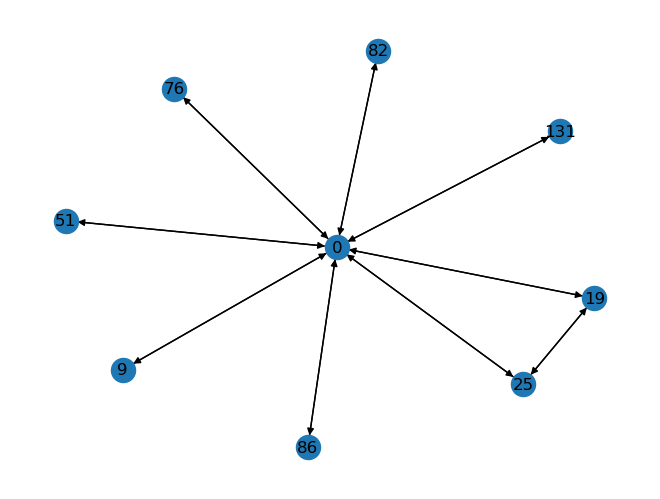

In [125]:
data = validation_dataset[0]
out = model(data.x.float(), data.edge_index)

G = torch_geometric.utils.convert.to_networkx(data)
subgraph = nx.ego_graph(G, 0, radius=1)
nx.draw(subgraph, with_labels = True)


mv = gensim.models.KeyedVectors(len(out[0]))
mv.add_vectors(list(map(str, list(range(0, len(out))))), out.detach().numpy())
print(mv.most_similar('0', topn=10))

mv = gensim.models.KeyedVectors(len(data.y[0]))
mv.add_vectors(list(map(str, list(range(0, len(data.y))))), data.y.numpy())
print(mv.most_similar('0', topn=10))